# Computing the nonadiabatic couplings in Kohn-Sham and Slater Determinant with mixed excitations bases

In this tutorial, we will start computing the nonadiabatic couplings (NACs) from the molecular orbital overlap files obtained in [step2](../../7_step2_cp2k/1_DFT). The NACs will be computed in the basis of Kohn-Sham states and also in the basis of mixed electron-hole excited Slater determinant (SD) bases. Finally we will plot the excited states energies vs time and NAC map.

This is an adaptation of [another example](../1_example_TiO2/tutorial.ipynb) but now focusing on a molecular system.

## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)


2. [Overview of required files](#required_files)


3. [Computing the NACs](#comp_nacs)     

   3.1. [Kohn-Sham basis](#KS)
    
   3.2. [Excited state basis](#excited_states)
    
    
4. [Plotting the results](#plotting)

   4.1. [NAC distribution](#nac_dist)
   
   4.2. [Energy vs time](#ene_time)
   
   4.3. [NAC map](#nac_map)
   

### A. Learning objectives

* To be able to compute the NACs in Kohn-Sham and excited state bases
* To be able to plot the NACs distribution 
* To be able to plot the computed excited states energies vs time
* To be able to plot the NAC map
* To be able to plot the average CI coefficients
* To be able to plot the average partial density of states

### B. Use cases

* [Computing the NACs](#comp_nacs)
* [Plotting the results](#plotting)


### C. Functions

- `libra_py`
  - `data_stat`
    - [`cmat_distrib`](#nac_dist)
  - `workflows`
      - [`step3`](#comp_nacs)
        - [`run_step3_ks_nacs_libint`](#KS)
        - [`run_step3_sd_nacs_libint`](#excited_states)
  - `units`
    - `au2ev`


## 1. Importing needed libraries <a name="import"></a>
[Back to TOC](#toc)

Since the data are stored in sparse format using `scipy.sparse` library, we need to load this library so that we can read and check the orthonormality of the data.
Import `numpy`, `scipy.sparse`, `CP2K_methods`, `data_stat`, `data_io`, `units`, `step2_many_body`, and `step3` modules. Also, `glob` will be needed to find specific types of files.

In [1]:
import os
import sys
import time
import glob
import math
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from liblibra_core import *
from libra_py.workflows.nbra import step3, step2_many_body
from libra_py import CP2K_methods, units, data_stat, data_io

/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/mnt/d/WORK/SOFTWARE/Conda/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<flo

## 2. Overview of required files <a name="required_files"></a>
[Back to TOC](#toc)

The file `step2.tar.gz` contains the needed directories. This is the results (also inputs for reference) computed in the step2 of the workflow

* `res` - contains the MO time-overlaps in the KS basis, are needed and stored in this folder.

* `all_logfiles` - contains all of the logfiles obtained from the electronic structure calculations of CP2K. These files are needed to find the Kohn-Sham HOMO index and also extract the the TD-DFT data for each step. This is primarily if we want to do the many-body (TD-DFT) states. 

To start, simply unpack the archive in the current directory:

    tar -xf step2.tar.gz
    

## 3. Computing the NACs 
[Back to TOC](#toc)

### 3.1. Kohn-Sham basis <a name="KS"></a>

The `libra_py.workflow.nbra.step3.run_step3_ks_nacs_libint(params)` computes the NACs between pairs of Kohn-Sham states using the molecular orbital overlaps. 

The paramters for this function are explained in [another document](../1_example_TiO2/tutorials.ipynb) as well as below:

In [2]:
help(step3.run_step3_ks_nacs_libint)

Help on function run_step3_ks_nacs_libint in module libra_py.workflows.nbra.step3:

run_step3_ks_nacs_libint(params)
    This function runs the step3 for computing NACs for Kohn-Sham states. 
    It performs phase-correction and orthonormalization for the overlaps.
    For now, we do not include the state reordering algorithm but will add it in
    the future.
    
    Args:
    
        params (dictionary):
    
            * **params['nprocs']** (integer): number of processors to be used.
            * **params['use_multiprocessing']**: the flag to use multiprocessing or not
            * **params['path_to_npz_files']** (string):  the path to the KS orbital overlaps which are stored 
                in .npz format in step2.
            * **params['time_step']** (float): the time-step in femtosecond
            * **params['path_to_save_ks_Hvibs']** (string): the path for storing the KS Hvibs
            * **params['path_to_save_sd_Hvibs']** (string): the path for saving the SD Hvibs
 

In the context of this function, the parameters `num_occ_states` and `num_unocc_states` can be considered the convenience/flexibility parameters. 

Consider that in step2 you have computed KS-basis time-overlaps for 200 occupied and 200 unoccupied orbitals, but you know that you are only concerned about excitations within only 20 occupied and 20 unoccupied ones. Through these parameters, you can reduce the size of the matrices that you'll be dealing with in the SD-basis calculations.

For the TD-DFT calculations, you need to include enough orbitals such that they include any orbitals {a, b} that appear in any TD-DFT SDs during the whole trajectory.

In this example, we start with the assumption that we have computed the time-overlaps for all 20 occupied and 20 unoccupuied orbitals. We do not wish to reduce these numbers, so whe use the numbers 20 and 20 for the `num_occ_states` and `num_unocc_states`

<a name="comp_nacs"></a>

In [5]:
%%time
params_ks = {
          'lowest_orbital': 28-20, 'highest_orbital': 28+20, 'num_occ_states': 20, 'num_unocc_states': 20,
          'use_multiprocessing': True,'nprocs': 4, 'time_step': 1.0, 'es_software': 'cp2k',
          'path_to_npz_files': os.getcwd()+'/step2/res',
          'logfile_directory': os.getcwd()+'/step2/all_logfiles',
          'path_to_save_ks_Hvibs': os.getcwd()+'/res-ks',
          'path_to_save_sd_Hvibs': os.getcwd()+'/res-ks',
          'start_time': 0, 'finish_time': 99,
          'apply_phase_correction': True, 'apply_orthonormalization': True,
          'do_state_reordering': 2, 'state_reordering_alpha':0
         }


#### For KS states - Applying correction to KS overlaps and computing the NACs in KS space
step3.run_step3_ks_nacs_libint(params_ks)

Computing orthonormalization of St matrices in step 21
Computing orthonormalization of St matrices in step 7
Computing orthonormalization of St matrices in step 0
Computing orthonormalization of St matrices in step 14
Done with step 21 . Elapsed time: 0.3316526412963867
Computing orthonormalization of St matrices in step 22
Done with step 7 . Elapsed time: 0.4204535484313965
Computing orthonormalization of St matrices in step 8
Done with step 0 . Elapsed time: 0.4814414978027344
Computing orthonormalization of St matrices in step 1
Done with step 14 . Elapsed time: 0.4970545768737793
Computing orthonormalization of St matrices in step 15
Done with step 22 . Elapsed time: 0.24290752410888672
Computing orthonormalization of St matrices in step 23
Done with step 8 . Elapsed time: 0.26036715507507324
Computing orthonormalization of St matrices in step 9
Done with step 1 . Elapsed time: 0.2347705364227295
Computing orthonormalization of St matrices in step 2
Done with step 15 . Elapsed time

Done with step 79 . Elapsed time: 0.21542716026306152
Computing orthonormalization of St matrices in step 80
Done with step 74 . Elapsed time: 0.31026577949523926
Computing orthonormalization of St matrices in step 75
Done with step 69 . Elapsed time: 0.15993976593017578
Computing orthonormalization of St matrices in step 84
Done with step 62 . Elapsed time: 0.2695600986480713
Computing orthonormalization of St matrices in step 91
Done with step 84 . Elapsed time: 0.18609213829040527
Computing orthonormalization of St matrices in step 85
Done with step 80 . Elapsed time: 0.3036351203918457
Computing orthonormalization of St matrices in step 81
Done with step 75 . Elapsed time: 0.2750880718231201
Computing orthonormalization of St matrices in step 76
Done with step 91 . Elapsed time: 0.2615468502044678
Computing orthonormalization of St matrices in step 92
Done with step 85 . Elapsed time: 0.19470739364624023
Computing orthonormalization of St matrices in step 86
Done with step 81 . Ela

### 3.2. Excited state basis 

Next, we compute the time-overlaps in the basis of SD excitations. This is done with the help of function `step3.run_step3_sd_nacs_libint`

The paramters for this function are explained in [another document](../1_example_TiO2/tutorials.ipynb) as well as below:

In [6]:
help(step3.run_step3_sd_nacs_libint)

Help on function run_step3_sd_nacs_libint in module libra_py.workflows.nbra.step3:

run_step3_sd_nacs_libint(params)
    This function runs the step3 for computing NACs between SDs. 
    It performs phase-correction and orthonormalization for the overlaps. 
    For now, we do not include state reordering algorithm but it will be added later.
    
    Args:
    
        params (dictionary):
    
            * **params['nprocs']** (integer): number of processors to be used.
            * **params['use_multiprocessing']** (bool): the flag to use multiprocessing or not.
            * **params['path_to_npz_files']** (string):  the path to the KS orbital overlaps which are stored 
                                                         in .npz file format in step2.
            * **params['time_step']** (float): the time-step in femtosecond
            * **params['path_to_save_ks_Hvibs']** (string): the path for storing the KS Hvibs
            * **params['path_to_save_sd_Hvibs']** (string):

The function automatically constructs the basis of SD excitations.

Pay special attention to the parameters `num_occ_states` and `num_unocc_states` - they define from how many orbitals the electron can be excited and to how many other orbitals it can be placed. 

The size of the created SD basis will then be roughly on the order of `num_occ_states  x num_unocc_states` scale.

If `num_occ_states = 1`, we construct the electron-only excitations basis

If `num_unocc_states = 1`, we construct the hole-only excitations basis


If the TD-DFT calculations has been done, then Libra will go over all log files and 
generate all the SDs used for all the steps and therefore the definition of these SDs is automatic and Libra will replace the `num_occ_states` and
`num_unocc_states` itself based on the SDs that were generated from the TD-DFT log files. 


In this example, we start with the simple excitations active space of (5, 5) meaning we excite from 5 occupied orbitals to 5 unoccupied ones

<a name="excited_states"></a>

In [7]:
%%time
#### For excited states - Computing the excited states SDs and their overlaps and NACs
# First, for mixed basis sorted by their energy
params_sd = {
          'lowest_orbital': 28-params_ks['num_occ_states']+1, 
          'highest_orbital': 28+params_ks['num_unocc_states'], 
          'num_occ_states': 5, 'num_unocc_states': 5,
          
          'isUKS': 0, 'number_of_states': 10, 'tolerance': 0.01, 'verbosity': 0, 
          'use_multiprocessing': True, 'nprocs': 4, 
          'is_many_body': False, 'time_step': 1.0, 'es_software': 'cp2k',
          'path_to_npz_files': os.getcwd()+'/res-ks',
          'logfile_directory': os.getcwd()+'/step2/all_logfiles',
          'path_to_save_sd_Hvibs': os.getcwd()+'/res-mixed-basis-energy',
          'outdir': os.getcwd()+'/res-mixed-basis-energy',
          'start_time': 0, 'finish_time': 99, 'sorting_type': 'energy',
          'apply_phase_correction': True, 'apply_orthonormalization': True,
          'do_state_reordering': 2, 'state_reordering_alpha':0
         }



step3.run_step3_sd_nacs_libint(params_sd)

sd_unique_basis is: [[[1, 6], 'alp'], [[1, 7], 'alp'], [[1, 8], 'alp'], [[1, 9], 'alp'], [[1, 10], 'alp'], [[2, 6], 'alp'], [[2, 7], 'alp'], [[2, 8], 'alp'], [[2, 9], 'alp'], [[2, 10], 'alp'], [[3, 6], 'alp'], [[3, 7], 'alp'], [[3, 8], 'alp'], [[3, 9], 'alp'], [[3, 10], 'alp'], [[4, 6], 'alp'], [[4, 7], 'alp'], [[4, 8], 'alp'], [[4, 9], 'alp'], [[4, 10], 'alp'], [[5, 6], 'alp'], [[5, 7], 'alp'], [[5, 8], 'alp'], [[5, 9], 'alp'], [[5, 10], 'alp']]
sd_states_reindexed is: [[1, -1, 2, -2, 3, -3, 4, -4, 5, -5], [6, -1, 2, -2, 3, -3, 4, -4, 5, -5], [7, -1, 2, -2, 3, -3, 4, -4, 5, -5], [8, -1, 2, -2, 3, -3, 4, -4, 5, -5], [9, -1, 2, -2, 3, -3, 4, -4, 5, -5], [10, -1, 2, -2, 3, -3, 4, -4, 5, -5], [1, -1, 6, -2, 3, -3, 4, -4, 5, -5], [1, -1, 7, -2, 3, -3, 4, -4, 5, -5], [1, -1, 8, -2, 3, -3, 4, -4, 5, -5], [1, -1, 9, -2, 3, -3, 4, -4, 5, -5], [1, -1, 10, -2, 3, -3, 4, -4, 5, -5], [1, -1, 2, -2, 6, -3, 4, -4, 5, -5], [1, -1, 2, -2, 7, -3, 4, -4, 5, -5], [1, -1, 2, -2, 8, -3, 4, -4, 5, -5], [1, 

Computing the SD overlaps for step 32
Done with computing the SD overlap of step 45. Elapsed time 0.10396027565002441
Applying orthonormalization for SDs for step 38
Applying orthonormalization for SDs for step 50
Computing the SD overlaps for step 46
Done with computing the SD overlap of step 38. Elapsed time 0.08257579803466797
Applying orthonormalization for SDs for step 32
Done with computing the SD overlap of step 50. Elapsed time 0.06995201110839844
Computing the SD overlaps for step 51
Computing the SD overlaps for step 39
Done with computing the SD overlap of step 32. Elapsed time 0.0922400951385498
Computing the SD overlaps for step 33
Applying orthonormalization for SDs for step 46
Applying orthonormalization for SDs for step 51
Done with computing the SD overlap of step 46. Elapsed time 0.09845089912414551
Applying orthonormalization for SDs for step 33
Computing the SD overlaps for step 47
Applying orthonormalization for SDs for step 39
Done with computing the SD overlap of

Applying orthonormalization for SDs for step 93
Applying orthonormalization for SDs for step 87
Done with computing the SD overlap of step 93. Elapsed time 0.06415939331054688
Computing the SD overlaps for step 94
Done with computing the SD overlap of step 87. Elapsed time 0.052703142166137695
Computing the SD overlaps for step 88
Applying orthonormalization for SDs for step 88
Applying orthonormalization for SDs for step 94
Done with computing the SD overlap of step 88. Elapsed time 0.05955815315246582
Computing the SD overlaps for step 89
Done with computing the SD overlap of step 94. Elapsed time 0.06657171249389648
Computing the SD overlaps for step 95
Applying orthonormalization for SDs for step 95
Applying orthonormalization for SDs for step 89
Done with computing the SD overlap of step 89. Elapsed time 0.038014888763427734
Done with computing the SD overlap of step 95. Elapsed time 0.03278994560241699
Computing the SD overlaps for step 90
Computing the SD overlaps for step 96
Ap

Now, let's repeat this for identity-ordered states

In [8]:
%%time
# Next, for mixed basis sorted by their identity
params_sd.update( { 'sorting_type': 'identity',
                    'path_to_save_sd_Hvibs': os.getcwd()+'/res-mixed-basis-identity', 
                    'outdir': os.getcwd()+'/res-mixed-basis-identity'               } )

step3.run_step3_sd_nacs_libint(params_sd)

sd_unique_basis is: [[[1, 6], 'alp'], [[1, 7], 'alp'], [[1, 8], 'alp'], [[1, 9], 'alp'], [[1, 10], 'alp'], [[2, 6], 'alp'], [[2, 7], 'alp'], [[2, 8], 'alp'], [[2, 9], 'alp'], [[2, 10], 'alp'], [[3, 6], 'alp'], [[3, 7], 'alp'], [[3, 8], 'alp'], [[3, 9], 'alp'], [[3, 10], 'alp'], [[4, 6], 'alp'], [[4, 7], 'alp'], [[4, 8], 'alp'], [[4, 9], 'alp'], [[4, 10], 'alp'], [[5, 6], 'alp'], [[5, 7], 'alp'], [[5, 8], 'alp'], [[5, 9], 'alp'], [[5, 10], 'alp']]
sd_states_reindexed is: [[1, -1, 2, -2, 3, -3, 4, -4, 5, -5], [6, -1, 2, -2, 3, -3, 4, -4, 5, -5], [7, -1, 2, -2, 3, -3, 4, -4, 5, -5], [8, -1, 2, -2, 3, -3, 4, -4, 5, -5], [9, -1, 2, -2, 3, -3, 4, -4, 5, -5], [10, -1, 2, -2, 3, -3, 4, -4, 5, -5], [1, -1, 6, -2, 3, -3, 4, -4, 5, -5], [1, -1, 7, -2, 3, -3, 4, -4, 5, -5], [1, -1, 8, -2, 3, -3, 4, -4, 5, -5], [1, -1, 9, -2, 3, -3, 4, -4, 5, -5], [1, -1, 10, -2, 3, -3, 4, -4, 5, -5], [1, -1, 2, -2, 6, -3, 4, -4, 5, -5], [1, -1, 2, -2, 7, -3, 4, -4, 5, -5], [1, -1, 2, -2, 8, -3, 4, -4, 5, -5], [1, 

Computing the SD overlaps for step 31
Applying orthonormalization for SDs for step 51
Done with computing the SD overlap of step 38. Elapsed time 0.08520054817199707
Applying orthonormalization for SDs for step 45
Done with computing the SD overlap of step 51. Elapsed time 0.10555005073547363
Computing the SD overlaps for step 39
Computing the SD overlaps for step 52
Applying orthonormalization for SDs for step 31
Done with computing the SD overlap of step 45. Elapsed time 0.07847428321838379
Computing the SD overlaps for step 46
Applying orthonormalization for SDs for step 39
Applying orthonormalization for SDs for step 52
Done with computing the SD overlap of step 31. Elapsed time 0.12460446357727051
Computing the SD overlaps for step 32
Applying orthonormalization for SDs for step 46
Done with computing the SD overlap of step 39. Elapsed time 0.08947277069091797
Computing the SD overlaps for step 40
Done with computing the SD overlap of step 52. Elapsed time 0.09797430038452148
Comp

Computing the SD overlaps for step 93
Done with computing the SD overlap of step 87. Elapsed time 0.056990623474121094
Computing the SD overlaps for step 88
Applying orthonormalization for SDs for step 93
Applying orthonormalization for SDs for step 88
Done with computing the SD overlap of step 93. Elapsed time 0.04767012596130371
Done with computing the SD overlap of step 88. Elapsed time 0.037110328674316406
Computing the SD overlaps for step 94
Computing the SD overlaps for step 89
Applying orthonormalization for SDs for step 89
Done with computing the SD overlap of step 89. Elapsed time 0.026492595672607422
Applying orthonormalization for SDs for step 94
Computing the SD overlaps for step 90
Done with computing the SD overlap of step 94. Elapsed time 0.04252147674560547
Computing the SD overlaps for step 95
Applying orthonormalization for SDs for step 90
Done with computing the SD overlap of step 90. Elapsed time 0.039365530014038086
Applying orthonormalization for SDs for step 95


### 3.3. Bigger SD bases

In [9]:
%%time
params_sd.update({'num_occ_states': 10, 'num_unocc_states': 10,
                  'sorting_type': 'energy',
                  'path_to_save_sd_Hvibs': os.getcwd()+'/res-mixed-basis-energy-10-10', 
                  'outdir': os.getcwd()+'/res-mixed-basis-energy-10-10'             })
step3.run_step3_sd_nacs_libint(params_sd)

sd_unique_basis is: [[[1, 11], 'alp'], [[1, 12], 'alp'], [[1, 13], 'alp'], [[1, 14], 'alp'], [[1, 15], 'alp'], [[1, 16], 'alp'], [[1, 17], 'alp'], [[1, 18], 'alp'], [[1, 19], 'alp'], [[1, 20], 'alp'], [[2, 11], 'alp'], [[2, 12], 'alp'], [[2, 13], 'alp'], [[2, 14], 'alp'], [[2, 15], 'alp'], [[2, 16], 'alp'], [[2, 17], 'alp'], [[2, 18], 'alp'], [[2, 19], 'alp'], [[2, 20], 'alp'], [[3, 11], 'alp'], [[3, 12], 'alp'], [[3, 13], 'alp'], [[3, 14], 'alp'], [[3, 15], 'alp'], [[3, 16], 'alp'], [[3, 17], 'alp'], [[3, 18], 'alp'], [[3, 19], 'alp'], [[3, 20], 'alp'], [[4, 11], 'alp'], [[4, 12], 'alp'], [[4, 13], 'alp'], [[4, 14], 'alp'], [[4, 15], 'alp'], [[4, 16], 'alp'], [[4, 17], 'alp'], [[4, 18], 'alp'], [[4, 19], 'alp'], [[4, 20], 'alp'], [[5, 11], 'alp'], [[5, 12], 'alp'], [[5, 13], 'alp'], [[5, 14], 'alp'], [[5, 15], 'alp'], [[5, 16], 'alp'], [[5, 17], 'alp'], [[5, 18], 'alp'], [[5, 19], 'alp'], [[5, 20], 'alp'], [[6, 11], 'alp'], [[6, 12], 'alp'], [[6, 13], 'alp'], [[6, 14], 'alp'], [[6, 15

Done with sorting and computing the SDs energies. Elapsed time: 1.5340707302093506
Computing the SD overlaps for step 7
Computing the SD overlaps for step 0
Computing the SD overlaps for step 14
Computing the SD overlaps for step 21
Applying orthonormalization for SDs for step 0
Applying orthonormalization for SDs for step 14
Applying orthonormalization for SDs for step 7
Applying orthonormalization for SDs for step 21
Done with computing the SD overlap of step 14. Elapsed time 0.5536456108093262
Computing the SD overlaps for step 15
Done with computing the SD overlap of step 0. Elapsed time 0.5673878192901611
Computing the SD overlaps for step 1
Done with computing the SD overlap of step 21. Elapsed time 0.6535859107971191
Computing the SD overlaps for step 22
Done with computing the SD overlap of step 7. Elapsed time 0.7315709590911865
Computing the SD overlaps for step 8
Applying orthonormalization for SDs for step 15
Done with computing the SD overlap of step 15. Elapsed time 0.457

Computing the SD overlaps for step 41
Applying orthonormalization for SDs for step 33
Done with computing the SD overlap of step 33. Elapsed time 0.6626052856445312
Computing the SD overlaps for step 34
Applying orthonormalization for SDs for step 54
Done with computing the SD overlap of step 54. Elapsed time 0.6532025337219238
Computing the SD overlaps for step 55
Applying orthonormalization for SDs for step 47
Done with computing the SD overlap of step 47. Elapsed time 0.6330926418304443
Computing the SD overlaps for step 48
Applying orthonormalization for SDs for step 41
Done with computing the SD overlap of step 41. Elapsed time 0.635284423828125
Computing the SD overlaps for step 56
Applying orthonormalization for SDs for step 34
Done with computing the SD overlap of step 34. Elapsed time 0.5529494285583496
Computing the SD overlaps for step 63
Applying orthonormalization for SDs for step 55
Done with computing the SD overlap of step 55. Elapsed time 0.5996038913726807
Computing t

Applying phase-correction to St_sd matrix of step 8
Applying phase-correction to St_sd matrix of step 9
Applying phase-correction to St_sd matrix of step 10
Applying phase-correction to St_sd matrix of step 11
Applying phase-correction to St_sd matrix of step 12
Applying phase-correction to St_sd matrix of step 13
Applying phase-correction to St_sd matrix of step 14
Applying phase-correction to St_sd matrix of step 15
Applying phase-correction to St_sd matrix of step 16
Applying phase-correction to St_sd matrix of step 17
Applying phase-correction to St_sd matrix of step 18
Applying phase-correction to St_sd matrix of step 19
Applying phase-correction to St_sd matrix of step 20
Applying phase-correction to St_sd matrix of step 21
Applying phase-correction to St_sd matrix of step 22
Applying phase-correction to St_sd matrix of step 23
Applying phase-correction to St_sd matrix of step 24
Applying phase-correction to St_sd matrix of step 25
Applying phase-correction to St_sd matrix of ste

In [10]:
%%time
params_sd.update({'num_occ_states': 20, 'num_unocc_states': 20,
                  'sorting_type': 'energy',
                  'path_to_save_sd_Hvibs': os.getcwd()+'/res-mixed-basis-energy-20-20', 
                  'outdir': os.getcwd()+'/res-mixed-basis-energy-20-20'             })
step3.run_step3_sd_nacs_libint(params_sd)

sd_unique_basis is: [[[1, 21], 'alp'], [[1, 22], 'alp'], [[1, 23], 'alp'], [[1, 24], 'alp'], [[1, 25], 'alp'], [[1, 26], 'alp'], [[1, 27], 'alp'], [[1, 28], 'alp'], [[1, 29], 'alp'], [[1, 30], 'alp'], [[1, 31], 'alp'], [[1, 32], 'alp'], [[1, 33], 'alp'], [[1, 34], 'alp'], [[1, 35], 'alp'], [[1, 36], 'alp'], [[1, 37], 'alp'], [[1, 38], 'alp'], [[1, 39], 'alp'], [[1, 40], 'alp'], [[2, 21], 'alp'], [[2, 22], 'alp'], [[2, 23], 'alp'], [[2, 24], 'alp'], [[2, 25], 'alp'], [[2, 26], 'alp'], [[2, 27], 'alp'], [[2, 28], 'alp'], [[2, 29], 'alp'], [[2, 30], 'alp'], [[2, 31], 'alp'], [[2, 32], 'alp'], [[2, 33], 'alp'], [[2, 34], 'alp'], [[2, 35], 'alp'], [[2, 36], 'alp'], [[2, 37], 'alp'], [[2, 38], 'alp'], [[2, 39], 'alp'], [[2, 40], 'alp'], [[3, 21], 'alp'], [[3, 22], 'alp'], [[3, 23], 'alp'], [[3, 24], 'alp'], [[3, 25], 'alp'], [[3, 26], 'alp'], [[3, 27], 'alp'], [[3, 28], 'alp'], [[3, 29], 'alp'], [[3, 30], 'alp'], [[3, 31], 'alp'], [[3, 32], 'alp'], [[3, 33], 'alp'], [[3, 34], 'alp'], [[3, 35

Done with sorting and computing the SDs energies. Elapsed time: 7.0388994216918945
Computing the SD overlaps for step 0
Computing the SD overlaps for step 7
Computing the SD overlaps for step 14
Computing the SD overlaps for step 21
Applying orthonormalization for SDs for step 14
Applying orthonormalization for SDs for step 0
Applying orthonormalization for SDs for step 7
Done with computing the SD overlap of step 14. Elapsed time 9.457448959350586
Computing the SD overlaps for step 15
Done with computing the SD overlap of step 0. Elapsed time 9.791351318359375
Computing the SD overlaps for step 1
Applying orthonormalization for SDs for step 21
Done with computing the SD overlap of step 7. Elapsed time 10.136130571365356
Computing the SD overlaps for step 8
Done with computing the SD overlap of step 21. Elapsed time 10.540283918380737
Computing the SD overlaps for step 22
Applying orthonormalization for SDs for step 8
Applying orthonormalization for SDs for step 15
Applying orthonormal

Computing the SD overlaps for step 34
Applying orthonormalization for SDs for step 47
Done with computing the SD overlap of step 47. Elapsed time 8.901677131652832
Computing the SD overlaps for step 48
Applying orthonormalization for SDs for step 40
Done with computing the SD overlap of step 40. Elapsed time 11.677697658538818
Computing the SD overlaps for step 41
Applying orthonormalization for SDs for step 54
Done with computing the SD overlap of step 54. Elapsed time 9.536398887634277
Computing the SD overlaps for step 55
Applying orthonormalization for SDs for step 34
Done with computing the SD overlap of step 34. Elapsed time 9.630774736404419
Computing the SD overlaps for step 56
Applying orthonormalization for SDs for step 48
Done with computing the SD overlap of step 48. Elapsed time 9.240830898284912
Computing the SD overlaps for step 63
Applying orthonormalization for SDs for step 41
Done with computing the SD overlap of step 41. Elapsed time 10.170157432556152
Computing the 

Applying phase-correction to St_sd matrix of step 2
Applying phase-correction to St_sd matrix of step 3
Applying phase-correction to St_sd matrix of step 4
Applying phase-correction to St_sd matrix of step 5
Applying phase-correction to St_sd matrix of step 6
Applying phase-correction to St_sd matrix of step 7
Applying phase-correction to St_sd matrix of step 8
Applying phase-correction to St_sd matrix of step 9
Applying phase-correction to St_sd matrix of step 10
Applying phase-correction to St_sd matrix of step 11
Applying phase-correction to St_sd matrix of step 12
Applying phase-correction to St_sd matrix of step 13
Applying phase-correction to St_sd matrix of step 14
Applying phase-correction to St_sd matrix of step 15
Applying phase-correction to St_sd matrix of step 16
Applying phase-correction to St_sd matrix of step 17
Applying phase-correction to St_sd matrix of step 18
Applying phase-correction to St_sd matrix of step 19
Applying phase-correction to St_sd matrix of step 20
A

In [11]:
%%time
params_sd.update({'num_occ_states': 10, 'num_unocc_states': 10,
                  'sorting_type': 'identity',
                  'path_to_save_sd_Hvibs': os.getcwd()+'/res-mixed-basis-identity-10-10', 
                  'outdir': os.getcwd()+'/res-mixed-basis-identity-10-10'             })
step3.run_step3_sd_nacs_libint(params_sd)

sd_unique_basis is: [[[1, 11], 'alp'], [[1, 12], 'alp'], [[1, 13], 'alp'], [[1, 14], 'alp'], [[1, 15], 'alp'], [[1, 16], 'alp'], [[1, 17], 'alp'], [[1, 18], 'alp'], [[1, 19], 'alp'], [[1, 20], 'alp'], [[2, 11], 'alp'], [[2, 12], 'alp'], [[2, 13], 'alp'], [[2, 14], 'alp'], [[2, 15], 'alp'], [[2, 16], 'alp'], [[2, 17], 'alp'], [[2, 18], 'alp'], [[2, 19], 'alp'], [[2, 20], 'alp'], [[3, 11], 'alp'], [[3, 12], 'alp'], [[3, 13], 'alp'], [[3, 14], 'alp'], [[3, 15], 'alp'], [[3, 16], 'alp'], [[3, 17], 'alp'], [[3, 18], 'alp'], [[3, 19], 'alp'], [[3, 20], 'alp'], [[4, 11], 'alp'], [[4, 12], 'alp'], [[4, 13], 'alp'], [[4, 14], 'alp'], [[4, 15], 'alp'], [[4, 16], 'alp'], [[4, 17], 'alp'], [[4, 18], 'alp'], [[4, 19], 'alp'], [[4, 20], 'alp'], [[5, 11], 'alp'], [[5, 12], 'alp'], [[5, 13], 'alp'], [[5, 14], 'alp'], [[5, 15], 'alp'], [[5, 16], 'alp'], [[5, 17], 'alp'], [[5, 18], 'alp'], [[5, 19], 'alp'], [[5, 20], 'alp'], [[6, 11], 'alp'], [[6, 12], 'alp'], [[6, 13], 'alp'], [[6, 14], 'alp'], [[6, 15

Done with sorting and computing the SDs energies. Elapsed time: 1.5765981674194336
Computing the SD overlaps for step 7
Computing the SD overlaps for step 0
Computing the SD overlaps for step 14
Computing the SD overlaps for step 21
Applying orthonormalization for SDs for step 7
Applying orthonormalization for SDs for step 21
Applying orthonormalization for SDs for step 0
Applying orthonormalization for SDs for step 14
Done with computing the SD overlap of step 7. Elapsed time 0.5843524932861328
Computing the SD overlaps for step 8
Done with computing the SD overlap of step 0. Elapsed time 0.6095075607299805
Computing the SD overlaps for step 1
Done with computing the SD overlap of step 14. Elapsed time 0.7777156829833984
Computing the SD overlaps for step 15
Done with computing the SD overlap of step 21. Elapsed time 0.8021485805511475
Computing the SD overlaps for step 22
Applying orthonormalization for SDs for step 8
Done with computing the SD overlap of step 8. Elapsed time 0.51998

Applying orthonormalization for SDs for step 40
Computing the SD overlaps for step 34
Done with computing the SD overlap of step 40. Elapsed time 0.6531693935394287
Computing the SD overlaps for step 41
Applying orthonormalization for SDs for step 54
Applying orthonormalization for SDs for step 47
Done with computing the SD overlap of step 54. Elapsed time 0.5911309719085693
Computing the SD overlaps for step 55
Done with computing the SD overlap of step 47. Elapsed time 0.6989445686340332
Computing the SD overlaps for step 48
Applying orthonormalization for SDs for step 34
Done with computing the SD overlap of step 34. Elapsed time 0.6245038509368896
Applying orthonormalization for SDs for step 41
Computing the SD overlaps for step 56
Done with computing the SD overlap of step 41. Elapsed time 0.6067483425140381
Computing the SD overlaps for step 63
Applying orthonormalization for SDs for step 55
Done with computing the SD overlap of step 55. Elapsed time 0.5646135807037354
Computing 

Applying phase-correction to St_sd matrix of step 7
Applying phase-correction to St_sd matrix of step 8
Applying phase-correction to St_sd matrix of step 9
Applying phase-correction to St_sd matrix of step 10
Applying phase-correction to St_sd matrix of step 11
Applying phase-correction to St_sd matrix of step 12
Applying phase-correction to St_sd matrix of step 13
Applying phase-correction to St_sd matrix of step 14
Applying phase-correction to St_sd matrix of step 15
Applying phase-correction to St_sd matrix of step 16
Applying phase-correction to St_sd matrix of step 17
Applying phase-correction to St_sd matrix of step 18
Applying phase-correction to St_sd matrix of step 19
Applying phase-correction to St_sd matrix of step 20
Applying phase-correction to St_sd matrix of step 21
Applying phase-correction to St_sd matrix of step 22
Applying phase-correction to St_sd matrix of step 23
Applying phase-correction to St_sd matrix of step 24
Applying phase-correction to St_sd matrix of step

In [12]:
%%time
params_sd.update({'num_occ_states': 20, 'num_unocc_states': 20,
                  'sorting_type': 'identity',
                  'path_to_save_sd_Hvibs': os.getcwd()+'/res-mixed-basis-identity-20-20', 
                  'outdir': os.getcwd()+'/res-mixed-basis-identity-20-20'             })
step3.run_step3_sd_nacs_libint(params_sd)

sd_unique_basis is: [[[1, 21], 'alp'], [[1, 22], 'alp'], [[1, 23], 'alp'], [[1, 24], 'alp'], [[1, 25], 'alp'], [[1, 26], 'alp'], [[1, 27], 'alp'], [[1, 28], 'alp'], [[1, 29], 'alp'], [[1, 30], 'alp'], [[1, 31], 'alp'], [[1, 32], 'alp'], [[1, 33], 'alp'], [[1, 34], 'alp'], [[1, 35], 'alp'], [[1, 36], 'alp'], [[1, 37], 'alp'], [[1, 38], 'alp'], [[1, 39], 'alp'], [[1, 40], 'alp'], [[2, 21], 'alp'], [[2, 22], 'alp'], [[2, 23], 'alp'], [[2, 24], 'alp'], [[2, 25], 'alp'], [[2, 26], 'alp'], [[2, 27], 'alp'], [[2, 28], 'alp'], [[2, 29], 'alp'], [[2, 30], 'alp'], [[2, 31], 'alp'], [[2, 32], 'alp'], [[2, 33], 'alp'], [[2, 34], 'alp'], [[2, 35], 'alp'], [[2, 36], 'alp'], [[2, 37], 'alp'], [[2, 38], 'alp'], [[2, 39], 'alp'], [[2, 40], 'alp'], [[3, 21], 'alp'], [[3, 22], 'alp'], [[3, 23], 'alp'], [[3, 24], 'alp'], [[3, 25], 'alp'], [[3, 26], 'alp'], [[3, 27], 'alp'], [[3, 28], 'alp'], [[3, 29], 'alp'], [[3, 30], 'alp'], [[3, 31], 'alp'], [[3, 32], 'alp'], [[3, 33], 'alp'], [[3, 34], 'alp'], [[3, 35

Done with sorting and computing the SDs energies. Elapsed time: 7.139668226242065
Computing the SD overlaps for step 0
Computing the SD overlaps for step 7
Computing the SD overlaps for step 14
Computing the SD overlaps for step 21
Applying orthonormalization for SDs for step 21
Applying orthonormalization for SDs for step 7
Done with computing the SD overlap of step 21. Elapsed time 8.546282529830933
Computing the SD overlaps for step 22
Done with computing the SD overlap of step 7. Elapsed time 8.602157592773438
Computing the SD overlaps for step 8
Applying orthonormalization for SDs for step 14
Applying orthonormalization for SDs for step 0
Done with computing the SD overlap of step 0. Elapsed time 11.491955995559692
Computing the SD overlaps for step 1
Done with computing the SD overlap of step 14. Elapsed time 11.626991033554077
Computing the SD overlaps for step 15
Applying orthonormalization for SDs for step 22
Done with computing the SD overlap of step 22. Elapsed time 9.375957

Computing the SD overlaps for step 34
Applying orthonormalization for SDs for step 47
Done with computing the SD overlap of step 47. Elapsed time 10.214014053344727
Computing the SD overlaps for step 48
Applying orthonormalization for SDs for step 40
Done with computing the SD overlap of step 40. Elapsed time 11.165509700775146
Computing the SD overlaps for step 41
Applying orthonormalization for SDs for step 54
Done with computing the SD overlap of step 54. Elapsed time 11.376649379730225
Computing the SD overlaps for step 55
Applying orthonormalization for SDs for step 34
Done with computing the SD overlap of step 34. Elapsed time 10.081916093826294
Computing the SD overlaps for step 56
Applying orthonormalization for SDs for step 41
Done with computing the SD overlap of step 41. Elapsed time 10.047433376312256
Computing the SD overlaps for step 63
Applying orthonormalization for SDs for step 48
Done with computing the SD overlap of step 48. Elapsed time 11.32231879234314
Computing t

Applying phase-correction to St_sd matrix of step 2
Applying phase-correction to St_sd matrix of step 3
Applying phase-correction to St_sd matrix of step 4
Applying phase-correction to St_sd matrix of step 5
Applying phase-correction to St_sd matrix of step 6
Applying phase-correction to St_sd matrix of step 7
Applying phase-correction to St_sd matrix of step 8
Applying phase-correction to St_sd matrix of step 9
Applying phase-correction to St_sd matrix of step 10
Applying phase-correction to St_sd matrix of step 11
Applying phase-correction to St_sd matrix of step 12
Applying phase-correction to St_sd matrix of step 13
Applying phase-correction to St_sd matrix of step 14
Applying phase-correction to St_sd matrix of step 15
Applying phase-correction to St_sd matrix of step 16
Applying phase-correction to St_sd matrix of step 17
Applying phase-correction to St_sd matrix of step 18
Applying phase-correction to St_sd matrix of step 19
Applying phase-correction to St_sd matrix of step 20
A

## 4. Plotting the results <a name='plotting'></a>
[Back to TOC](#toc)

### 4.1. NAC distribution <a name='nac_dist'></a>

One of the intuitive ways to visualize the NACs is to plot the distribution of the NACs. Here we plot them for SP and MB excited states.

<IPython.core.display.Javascript object>


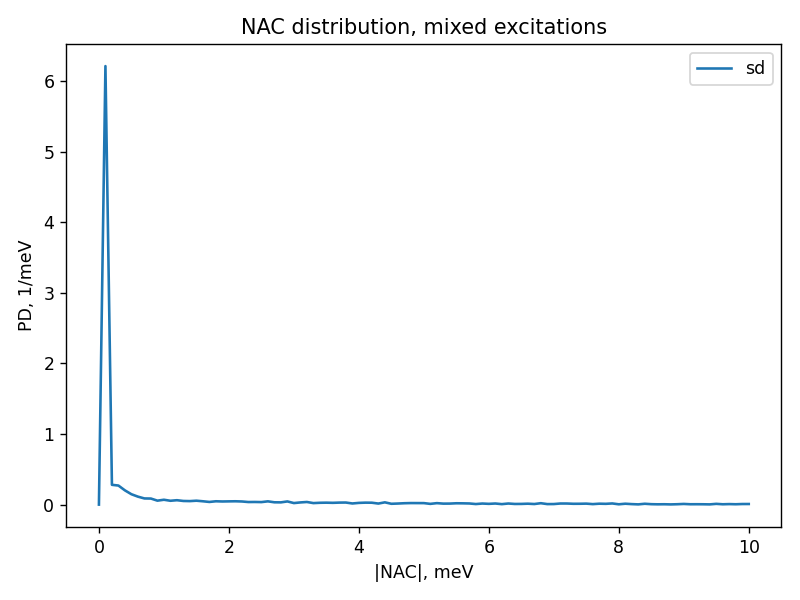

In [13]:
%matplotlib notebook

for basis in ['sd']:
    nac = []
    nac_files = glob.glob(F'res-mixed-basis-energy/Hvib_{basis}*im*')
    for nac_file in nac_files:
        hvib = sp.load_npz(nac_file)
        hvib_dense = hvib.todense().real
        for i in range(hvib.shape[0]):
            for j in range(hvib.shape[0]):
                if j != i:
                    nac_ij = np.abs(hvib_dense[i,j])* 1000.0 * units.au2ev
                    x_mb = MATRIX(1,1)
                    x_mb.set(0, 0, nac_ij )
                    nac.append( x_mb )
    bin_supp, dens, cum = data_stat.cmat_distrib( nac, 0, 0, 0, 0, 10, 0.1)
    plt.plot( bin_supp, dens, label=basis)
plt.xlabel('|NAC|, meV')
plt.ylabel('PD, 1/meV')
plt.title('NAC distribution, mixed excitations')
plt.legend()
plt.tight_layout()
# plt.savefig('nac_dist_1.jpg', dpi=600)

### 4.2. Energy vs time <a name='ene_time'></a>
Here, we plot the excited states energy vs time. Since the excited states were sorted by their `'identity'` it is easy to visualize the states energies crossings.

<IPython.core.display.Javascript object>


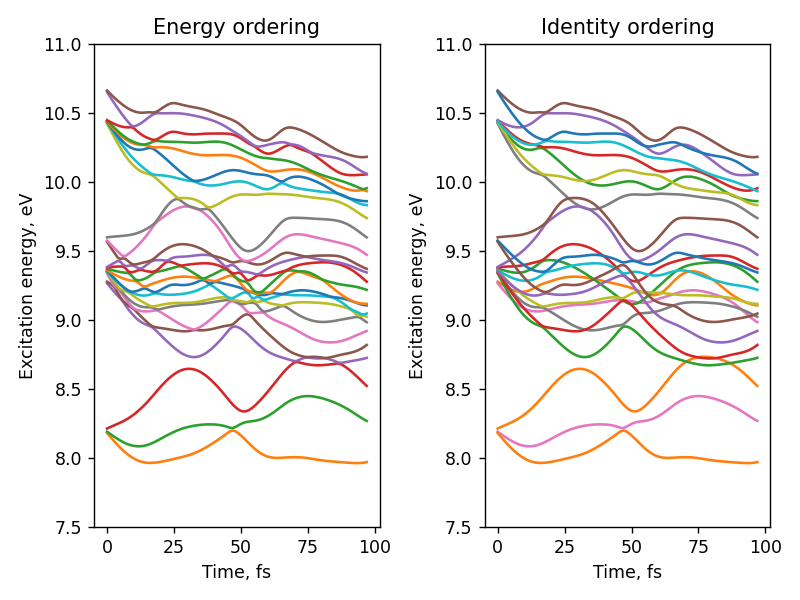

In [14]:
%matplotlib notebook
titles = ['Energy ordering', "Identity ordering" ]
plt.figure()
for c, basis in enumerate(['sd', 'sd']):
    plt.subplot(1,2,c+1)
    if c==0:
        energy_files = glob.glob(F'res-mixed-basis-energy/Hvib_{basis}*re*')
    elif c==1:
        energy_files = glob.glob(F'res-mixed-basis-identity/Hvib_{basis}*re*')
    
    energy_files = data_io.sort_hvib_file_names(energy_files)
    #print('Sorted energy files are:', energy_files)
    dt = 1.0 # fs
    energies = []
    for file in energy_files:
        energies.append(np.diag(sp.load_npz(file).todense().real))
    energies = np.array(energies)*units.au2ev
    md_time = np.arange(0,energies.shape[0]*dt,dt)
    for i in range(energies.shape[1]):
        plt.plot(md_time, energies[:,i]-energies[:,0])
    
    plt.title(titles[c])
    plt.ylim( [7.5, 11.0] )
    plt.ylabel('Excitation energy, eV')
    plt.xlabel('Time, fs')
    plt.tight_layout()

#### Energy vs Time for bigger bases (Optionally)

<IPython.core.display.Javascript object>


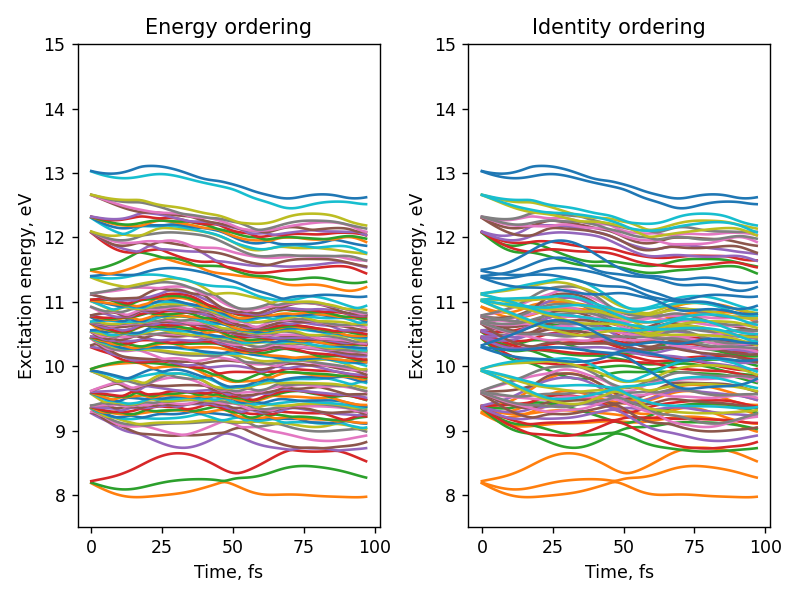

In [19]:
%matplotlib notebook
titles = ['Energy ordering', "Identity ordering" ]
plt.figure()
for c, basis in enumerate(['sd', 'sd']):
    plt.subplot(1,2,c+1)
    if c==0:
        energy_files = glob.glob(F'res-mixed-basis-energy-10-10/Hvib_{basis}*re*')
    elif c==1:
        energy_files = glob.glob(F'res-mixed-basis-identity-10-10/Hvib_{basis}*re*')
    
    energy_files = data_io.sort_hvib_file_names(energy_files)
    #print('Sorted energy files are:', energy_files)
    dt = 1.0 # fs
    energies = []
    for file in energy_files:
        energies.append(np.diag(sp.load_npz(file).todense().real))
    energies = np.array(energies)*units.au2ev
    md_time = np.arange(0,energies.shape[0]*dt,dt)
    for i in range(energies.shape[1]):
        plt.plot(md_time, energies[:,i]-energies[:,0])
    
    plt.title(titles[c])
    plt.ylim( [7.5, 15.0] )
    plt.ylabel('Excitation energy, eV')
    plt.xlabel('Time, fs')
    plt.tight_layout()

<IPython.core.display.Javascript object>


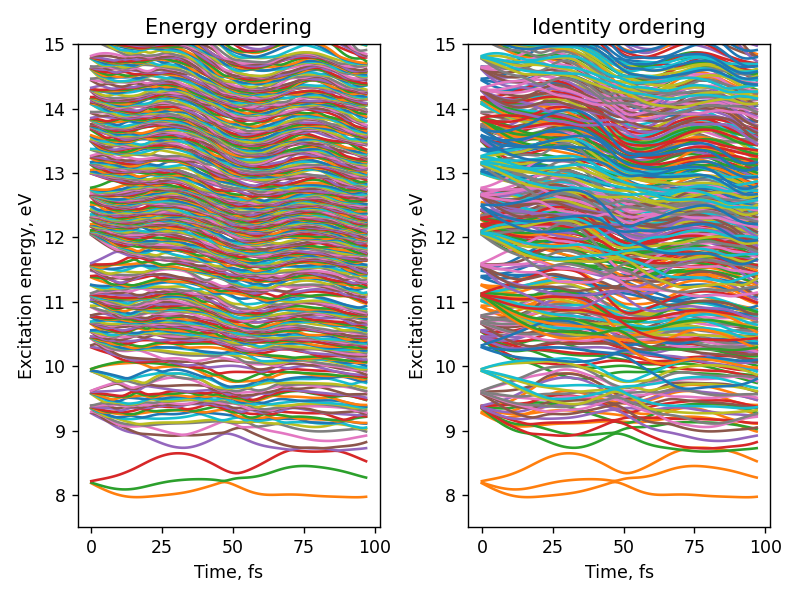

In [18]:
%matplotlib notebook
titles = ['Energy ordering', "Identity ordering" ]
plt.figure()
for c, basis in enumerate(['sd', 'sd']):
    plt.subplot(1,2,c+1)
    if c==0:
        energy_files = glob.glob(F'res-mixed-basis-energy-20-20/Hvib_{basis}*re*')
    elif c==1:
        energy_files = glob.glob(F'res-mixed-basis-identity-20-20/Hvib_{basis}*re*')
    
    energy_files = data_io.sort_hvib_file_names(energy_files)
    #print('Sorted energy files are:', energy_files)
    dt = 1.0 # fs
    energies = []
    for file in energy_files:
        energies.append(np.diag(sp.load_npz(file).todense().real))
    energies = np.array(energies)*units.au2ev
    md_time = np.arange(0,energies.shape[0]*dt,dt)
    for i in range(energies.shape[1]):
        plt.plot(md_time, energies[:,i]-energies[:,0])
    
    plt.title(titles[c])
    plt.ylim( [7.5, 15.0] )
    plt.ylabel('Excitation energy, eV')
    plt.xlabel('Time, fs')
    plt.tight_layout()

### 4.3. NAC map <a name='nac_map'></a>
Another way of visualizing the NAC values is to plot the average NAC matrix using `plt.imshow`.

<IPython.core.display.Javascript object>


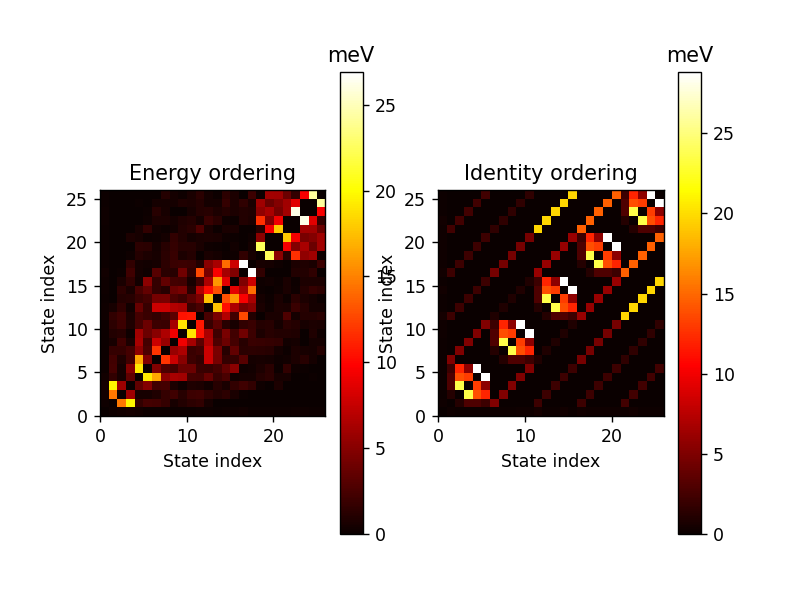

In [15]:
%matplotlib notebook
titles = ['Energy ordering', "Identity ordering" ]

plt.figure()

for c, basis in enumerate(['sd', 'sd']):
    plt.subplot(1,2,c+1)
    if c==0:
        nac_files = glob.glob(F'res-mixed-basis-energy/Hvib_{basis}*im*')
    elif c==1:
        nac_files = glob.glob(F'res-mixed-basis-identity/Hvib_{basis}*im*')


    for i, nac_file in enumerate(nac_files):
        nac_mat = sp.load_npz(nac_file).todense().real
        if i==0:
            nac_ave = np.zeros(nac_mat.shape)
        nac_ave += np.abs(nac_mat)
        
    nac_ave *= 1000*units.au2ev/i
    
    nstates = nac_ave.shape[0]
    plt.imshow(np.flipud(nac_ave), cmap='hot', extent=(0,nstates,0,nstates))#, vmin=0, vmax=100)
    plt.xlabel('State index')
    plt.ylabel('State index')
    plt.colorbar().ax.set_title('meV')
    plt.title(titles[c])
    
        

#### NAC map for bigger bases (Optionally) 

<IPython.core.display.Javascript object>


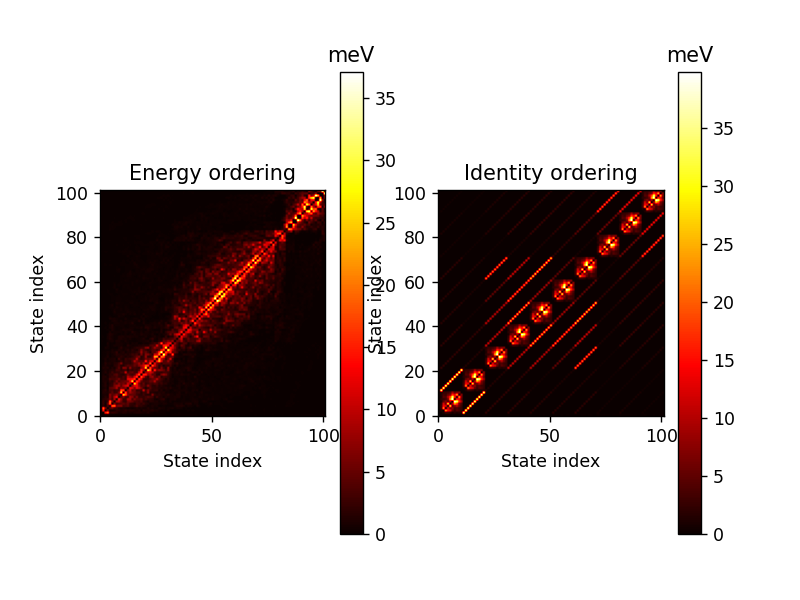

In [20]:
%matplotlib notebook
titles = ['Energy ordering', "Identity ordering" ]

plt.figure()

for c, basis in enumerate(['sd', 'sd']):
    plt.subplot(1,2,c+1)
    if c==0:
        nac_files = glob.glob(F'res-mixed-basis-energy-10-10/Hvib_{basis}*im*')
    elif c==1:
        nac_files = glob.glob(F'res-mixed-basis-identity-10-10/Hvib_{basis}*im*')


    for i, nac_file in enumerate(nac_files):
        nac_mat = sp.load_npz(nac_file).todense().real
        if i==0:
            nac_ave = np.zeros(nac_mat.shape)
        nac_ave += np.abs(nac_mat)
        
    nac_ave *= 1000*units.au2ev/i
    
    nstates = nac_ave.shape[0]
    plt.imshow(np.flipud(nac_ave), cmap='hot', extent=(0,nstates,0,nstates))#, vmin=0, vmax=100)
    plt.xlabel('State index')
    plt.ylabel('State index')
    plt.colorbar().ax.set_title('meV')
    plt.title(titles[c])
    

<IPython.core.display.Javascript object>


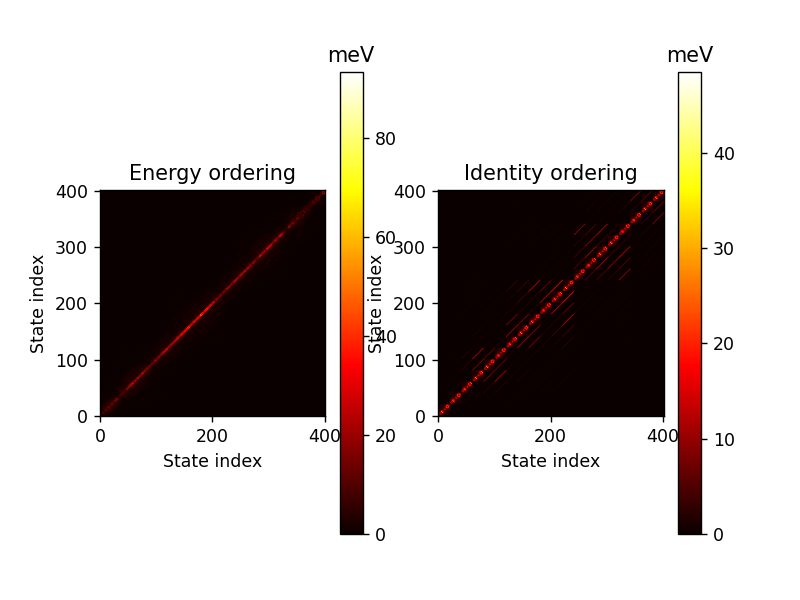

In [21]:
%matplotlib notebook
titles = ['Energy ordering', "Identity ordering" ]

plt.figure()

for c, basis in enumerate(['sd', 'sd']):
    plt.subplot(1,2,c+1)
    if c==0:
        nac_files = glob.glob(F'res-mixed-basis-energy-20-20/Hvib_{basis}*im*')
    elif c==1:
        nac_files = glob.glob(F'res-mixed-basis-identity-20-20/Hvib_{basis}*im*')


    for i, nac_file in enumerate(nac_files):
        nac_mat = sp.load_npz(nac_file).todense().real
        if i==0:
            nac_ave = np.zeros(nac_mat.shape)
        nac_ave += np.abs(nac_mat)
        
    nac_ave *= 1000*units.au2ev/i
    
    nstates = nac_ave.shape[0]
    plt.imshow(np.flipud(nac_ave), cmap='hot', extent=(0,nstates,0,nstates))#, vmin=0, vmax=100)
    plt.xlabel('State index')
    plt.ylabel('State index')
    plt.colorbar().ax.set_title('meV')
    plt.title(titles[c])
    